In [1]:
%pip install git+https://github.com/patrolSU2019/bbrl_gym.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/patrolSU2019/bbrl_gym.git to /tmp/pip-req-build-hnhl4i9y
  Running command git clone --filter=blob:none --quiet https://github.com/patrolSU2019/bbrl_gym.git /tmp/pip-req-build-hnhl4i9y
  Resolved https://github.com/patrolSU2019/bbrl_gym.git to commit 97e14fe616b2b534879e4b9371ff0c27f3681e6a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/patrolSU2019/SimpleMazeMDP.git (to revision master) to /tmp/pip-install-odia43_1/mazemdp_1d9e58bb42454eccaef606b858b443cc
  Running command git clone --filter=blob:none --quiet https://github.com/patrolSU2019/SimpleMazeMDP.git /tmp/pip-install-odia43_1/mazemdp_1d9e58bb42454eccaef606b858b443cc
  Resolved https://github.com/patrolSU2019/SimpleMazeMDP.git to commit 32a8f616

In [2]:
import os
from typing import Tuple, List

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from mazemdp.toolbox import egreedy, egreedy_loc, softmax, sample_categorical
from mazemdp.maze_plotter import show_videos
from mazemdp.mdp import Mdp
from bbrl_gym.envs.maze_mdp import MazeMDPEnv

# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

from IPython.display import Video

# Settings
NB_EPISODES = 50
TIMEOUT = 25


import gym
import bbrl_gym


env = gym.make("MazeMDP-v0", kwargs={"width": 3, "height": 3, "ratio": 0.2})
env.reset()

# set this False to render correctly in pycharm
# env.mdp.plotter.using_notebook = False

# in dynamic programming, there is no agent moving in the environment
env.init_draw("The maze")

Matplotlib backend: module://ipykernel.pylab.backend_inline


Output()

In [3]:
# --------------------------- Q-Learning epsilon-greedy version -------------------------------#

# Given an exploration rate epsilon, the QLearning algorithm computes the state action-value function
# based on an epsilon-greedy policy
# alpha is the learning rate

def get_policy_from_q(q: np.ndarray) -> np.ndarray:
    return np.argmax(q, axis=2)
    
def q_learning_eps(
    mdp: MazeMDPEnv,
    epsilon: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
) -> Tuple[np.ndarray, List[float], List[int]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.nb_states -1 ,mdp.action_space.n))
    q_list = []
    time_list = []

    # Run learning cycle
    mdp.set_timeout(timeout)  # episode length

    

    if render:
        mdp.init_draw(f"Q-learning e-greedy with goal")
    for goal in range(mdp.nb_states-1):
        mdp.change_last_states([goal])
        for _ in tqdm(range(nb_episodes)):
            # Draw the first state of episode i using a uniform distribution over all the states
            x = mdp.reset(uniform=True)
            done = False
        
            while not done:
                if render:
                    # Show the agent in the maze
                    mdp.draw_v_pi(q[:, goal, : ], np.argmax(q[:, goal, :], axis=1))


                # Draw an action using an epsilon-greedy policy
                u = egreedy(q[:, goal, : ], x, epsilon)

                # Perform a step of the MDP
                [y, r, done, _] = mdp.step(u)

                # Update the state-action value function
                delta = r + mdp.gamma * np.max(q[y, goal]) - q[x,goal,u]
                q[x,goal, u] = q[x,goal, u] + alpha * delta

                # Update the agent position
                x = y
            q_list.append(np.linalg.norm(q))
            time_list.append(mdp.mdp.timestep)

    # if render:
    #     # Show the final policy
    #     mdp.current_state = 0
    #     mdp.draw_v_pi(q, get_policy_from_q(q), title="Q-learning e-greedy")
    return q, q_list, time_list


In [4]:
q , q_list, time_list = q_learning_eps(env, 0.1, 20, 20, 0.5, True)

Output()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [10]:
def plot_ql_3d_goal_inorder(env, epsilon, tau, nb_episodes, timeout, alpha, render):
    q, _, t_list1 = q_learning_eps(env, epsilon, nb_episodes, timeout, alpha, render)

    plt.figure(figsize=(18,5))
    plt.plot(range(nb_episodes*(env.mdp.nb_states-1)), t_list1, label='q-learning epsilon')
    plt.xlabel('Number of episodes')
    plt.ylabel('Number of steps to reach the goal')
    plt.legend(loc='upper right')
    plt.title("Comparison of Time to reach the goal")
    plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

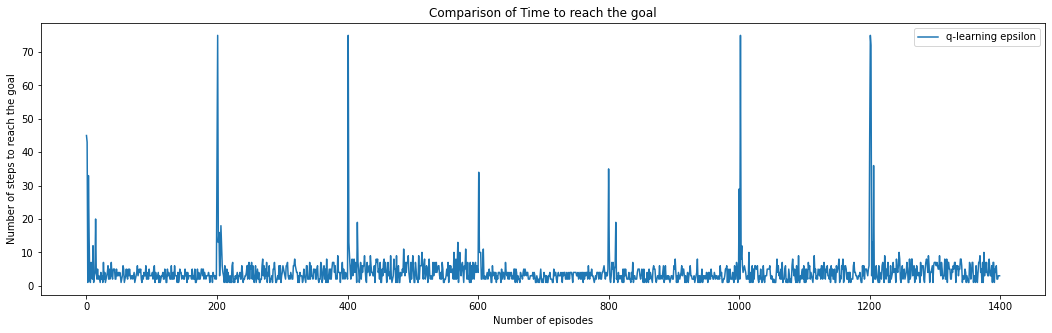

In [19]:
plot_ql_3d_goal_inorder(env, 0.1, 0.1, 200, 75, 0.5, False)